In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from tqdm import tqdm
DATA_ROOT = '../data/raw/YCup2021'
NUM_RECOMENDATIONS = 20
%matplotlib inline

### Сырые данные

### Считываем данные из .csv

Некоторые данные (такие как рубрики и признаки), представлены строками значений. Преобразуем их в списки чисел. 

In [2]:
to_list = lambda rubrics: [int(rubric) for rubric in str(rubrics).split(' ')]
def apply_to_columns(df, columns, func=to_list):
    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[~df[column].isnull(), column].apply(func)

В первую очередь нам понадобятся данные по __пользователям__, __организациям__ и сами __отзывы__. 

In [3]:
users = pd.read_csv(DATA_ROOT + '/users.csv')
users.head()

,user_id,city
0,523295021912509756,msk
1,11952159487361099606,msk
2,16879036589969590999,msk
3,12791716990148606332,msk
4,11642393216024958726,msk


In [4]:
orgs = pd.read_csv(DATA_ROOT+'/organisations.csv')

# create lists
columns = ['rubrics_id', 'features_id']
apply_to_columns(orgs, columns)

orgs.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,16848414477362211020,spb,1000.0,4.479702,"[30776, 31375]","[1018, 1509, 11177, 11617, 11629, 11704, 11867..."
1,1430604733320164116,spb,1000.0,4.514509,"[30776, 30770]","[246, 1018, 11617, 11629, 11704, 11867, 20422,..."
2,9880309324224147401,spb,1000.0,3.884615,"[30770, 30774]","[1018, 11177, 11617, 11629, 11704, 11867, 2042..."
3,5617879987171966456,spb,1000.0,NaN,"[30774, 30775]","[1018, 1509, 10596, 11177, 11629, 11634, 11704..."
4,5241461680470612149,spb,1000.0,4.532468,[30776],"[1018, 11177, 11617, 11629, 11704, 11867, 2042..."


Чтобы не делать __join__ каждый раз, когда нам потребуется узнать, из какого города организация или пользователь, сразу добавим эту информацию в отзывы.

In [5]:
reviews = pd.read_csv(DATA_ROOT+'/reviews.csv', low_memory=False)

# encode users ids as numeric
reviews = reviews.merge(users, on='user_id')
reviews = reviews.rename({'city': 'user_city'}, axis=1)

# # encode orgs ids as numeric
reviews = reviews.merge(orgs[['org_id', 'city']], on='org_id')
reviews = reviews.rename({'city': 'org_city'}, axis=1)

# # create lists
columns = ['aspects']
apply_to_columns(reviews, columns)

reviews.head()

,user_id,org_id,rating,ts,aspects,user_city,org_city
0,16998268288908323644,7184895086928047809,2.0,105,NaN,msk,msk
1,3121447338909258868,7184895086928047809,5.0,464,NaN,msk,msk
2,1970649778250883025,7184895086928047809,3.0,789,NaN,msk,msk
3,7554889464530643866,7184895086928047809,4.0,936,NaN,msk,msk
4,15907910894057053620,7184895086928047809,1.0,1143,NaN,msk,msk


### Парсим рубрики организаций

In [6]:
from collections import defaultdict, Counter
RUBRICS_MAPPING = defaultdict(lambda : -1)
RUBRICS_MAPPING.update(
    {
        #1)
        30519:0, # Булочная, пекарня
        31495:0, # Кофейня
        31350:0, # Кондитерская
        3501750896:0, # Кофе с собой

        #2)
        30770:1, # "Бар, паб"
        31286:1, # Спортбар

        #3)
        30771:2, # Быстрое питание
        3501514558:2, # Фудкорт

        #4)
        30774:3, # Кафе

        #5)
        30775:4, # Пиццерия
        #6)
        30776:5, # Ресторан
        #7)
        30777:6, # Столовая

        #8)
        31375:7, # Суши-бар
        #9)
        31401:8, # Кальян-бар
        #10)
        3108292683:9, # Бар безалкогольных напитков
    }
)
def rubric_mapper(to_single_rubric=True):
    def remap_rubrics(rubric_ids):
        observed_rubrics = Counter((RUBRICS_MAPPING[rubric_id] for rubric_id in rubric_ids))
        if to_single_rubric:
            return observed_rubrics.most_common(1)[0][0]
        else:
            [rubric for rubric, count in observed_rubrics.most_common(3)]
    return remap_rubrics
RUBRIC_MAPPER = rubric_mapper()
orgs_filled_bill = orgs

orgs_filled_bill['rubric_id'] = orgs_filled_bill.rubrics_id.apply(RUBRIC_MAPPER)

### Заполняем пустые поля среднего чека

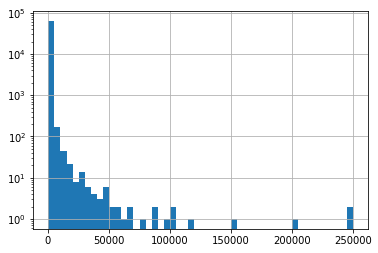

In [7]:
reviews_at_home = reviews
reviews_at_home = reviews_at_home.merge(orgs, on='org_id', how='inner')[['user_id', 'average_bill']].dropna()
average_bill_for_user = reviews_at_home.groupby('user_id')['average_bill'].mean()

visits_vs_user_cash = reviews.merge(average_bill_for_user, on='user_id', how='inner')
visits_vs_user_cash = visits_vs_user_cash.groupby('org_id')['average_bill'].mean()

orgs_filled_bill = orgs.copy().merge(visits_vs_user_cash, on='org_id', how='left')

completed_bill = orgs_filled_bill['average_bill_x'].where(~orgs_filled_bill.average_bill_x.isna(), orgs_filled_bill.average_bill_y)
completed_bill.hist(log=True, bins=50)
completed_bill.quantile(0.95)
orgs_filled_bill['average_bill'] = completed_bill

###  Исследование распределения данных

#### Посмотрим на распределение новых отзывов по дням, чтобы понять, как лучше организовать валидацию. 




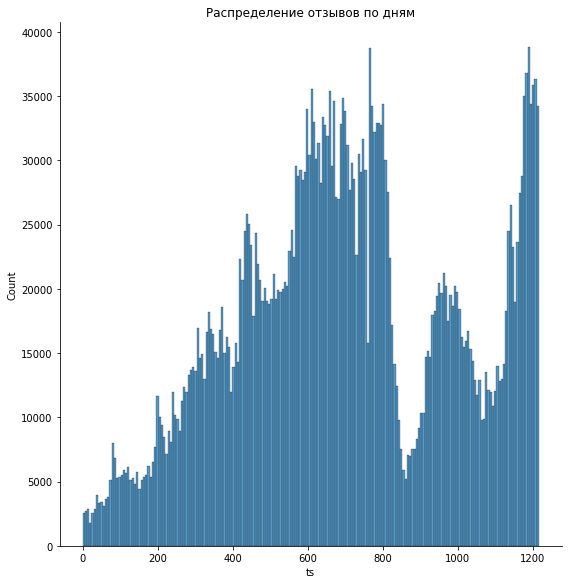

In [8]:
sns.displot(data=reviews, x='ts', height=8)
plt.title('Распределение отзывов по дням')
plt.show()

#### Все типы заведений, кроме безалкогольных баров распространены приблизительно одинаково

<AxesSubplot:>

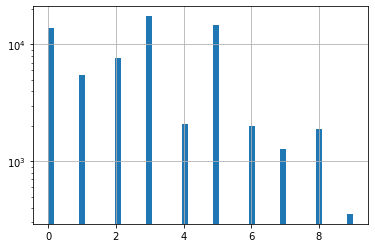

In [9]:
orgs_filled_bill['rubric_id'].hist(log=True, bins=50)

In [10]:
orgs_prep = orgs_filled_bill

#### Больша часть пользователей оставила только 1-2 отзыва. Это значит, что им не посоветовать ничего конкретного. Остается работать с пользователями у которых 5 и больше отызвов. Таких 142 000

181642


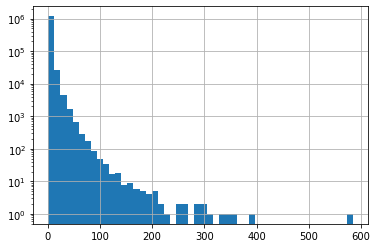

In [11]:
reviews_at_home = reviews[(reviews['org_city'] == reviews['user_city'])]

reviews_at_home = reviews_at_home.groupby('user_id')['org_id'].count()#.sort_values(ascending=False).head(15)
reviews_at_home.hist(log=True, bins=50)
print(len(reviews_at_home[reviews_at_home>=5].dropna()))

3500.0


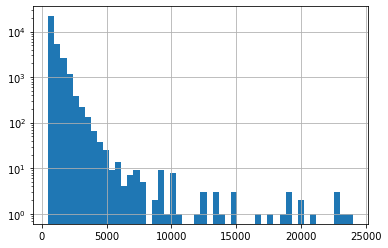

In [12]:
reviews_at_home = reviews#[(train_reviews['org_city'] == train_reviews['user_city'])]
reviews_at_home = reviews_at_home.merge(orgs, on='org_id', how='inner')[['org_id', 'average_bill']].dropna()
reviews_at_home = reviews_at_home.groupby('org_id')['average_bill'].max()#.sort_values(ascending=False).head(15)
reviews_at_home = reviews_at_home[reviews_at_home<=reviews_at_home.quantile(0.999)]
reviews_at_home.hist(log=True, bins=50)
print(reviews_at_home.quantile(0.99))

#### 99% чеков - до 3500 руб

<AxesSubplot:>

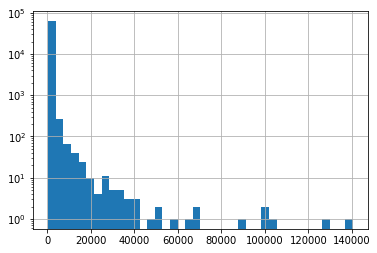

In [13]:
reviews_at_home = reviews#[(train_reviews['org_city'] == train_reviews['user_city'])]
reviews_at_home = reviews_at_home.merge(orgs, on='org_id', how='inner')[['user_id', 'average_bill']].dropna()
average_bill_for_user = reviews_at_home.groupby('user_id')['average_bill'].mean()#.sort_values(ascending=False).head(15)
# reviews_at_home = reviews_at_home[reviews_at_home<=reviews_at_home.quantile(0.999)]
# average_bill_for_user.hist(log=True, bins=50)
visits_vs_user_cash = reviews.merge(average_bill_for_user, on='user_id', how='inner')
visits_vs_user_cash = visits_vs_user_cash.groupby('org_id')['average_bill'].mean()
visits_vs_user_cash.hist(log=True, bins=40)


#### Распределение организаций по среднему чеку
Большая часть орагнизаций работают с чеком до 5k

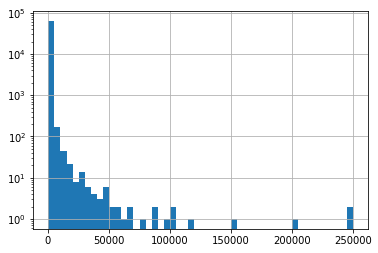

In [14]:
orgs_filled_bill = orgs.copy().merge(visits_vs_user_cash, on='org_id', how='left')
# bill_col = orgs_filled_bill['average_bill']
completed_bill = orgs_filled_bill['average_bill_x'].where(~orgs_filled_bill.average_bill_x.isna(), orgs_filled_bill.average_bill_y)
completed_bill.hist(log=True, bins=50)
completed_bill.quantile(0.95)
orgs_filled_bill['average_bill'] = completed_bill

#### Распределение юзов по количеству отзывов
У 80% юзов до 3х отзывов. Это значит, что 80% пользователей можно советовать только по массовой статистике.
И массовые отзывы можно использовать для накопления инфы и рекомендаций заведений тем, кто оставляет больше отзывов и инфы о себе

3.0


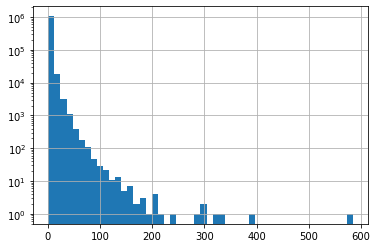

In [15]:
best_reviews_at_home = reviews[(reviews['rating'] >= 4) & (reviews['org_city'] == reviews['user_city'])]
best_reviews_at_home = best_reviews_at_home.merge(orgs, on='org_id', how='inner')

best_reviews_at_home['rubric_id'] = best_reviews_at_home['rubrics_id'].apply(RUBRIC_MAPPER)
best_reviews_by_user = best_reviews_at_home.groupby('user_id')['org_id'].count()#.sort_values(ascending=False).head(15)
best_reviews_by_user.hist(log=True, bins=50)
print(best_reviews_by_user.quantile(0.80))

#### Ищу временные зависимости в данных. Средний чек зависит от дня недели, но это слишком большое усреднение

<AxesSubplot:xlabel='ts'>

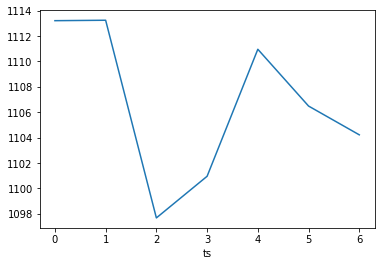

In [16]:
ts_vs_bill = reviews.merge(orgs_filled_bill, on='org_id', how='inner')[['ts', 'average_bill']]
ts_vs_bill['ts'] = ts_vs_bill['ts']%7
ts_vs_bill.groupby('ts')['average_bill'].mean().plot()

#### распределение отрицательных отзывов по юзам
отрицательных отзывов меньше положительных

2.0


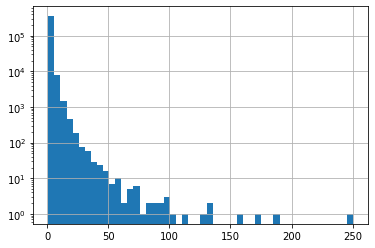

In [17]:
worst_reviews_at_home = reviews[(reviews['rating'] < 4) & (reviews['org_city'] == reviews['user_city'])]
worst_reviews_at_home = worst_reviews_at_home.merge(orgs, on='org_id', how='inner')

worst_reviews_at_home['rubric_id'] = worst_reviews_at_home['rubrics_id'].apply(RUBRIC_MAPPER)
worst_reviews_at_home = worst_reviews_at_home.groupby('user_id')['org_id'].count()#.sort_values(ascending=False).head(15)
worst_reviews_at_home.hist(log=True, bins=50)
print(worst_reviews_at_home.quantile(0.8))

In [18]:
num_reviews_range = (10,100)
review_tracks = reviews.groupby('org_id')['ts']
review_counters = review_tracks.count()
review_tracks = review_counters[review_counters > num_reviews_range[0]]
# review_tracks = reviews[reviews.org_id.isin(review_tracks.index)].groupby('org_id')['ts']
